ELEG815 HW 8 Programming problem       
J. Cristiano       
11/6/2024    


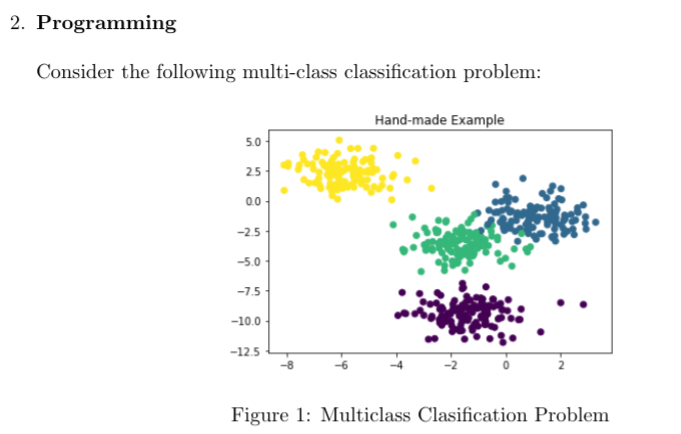
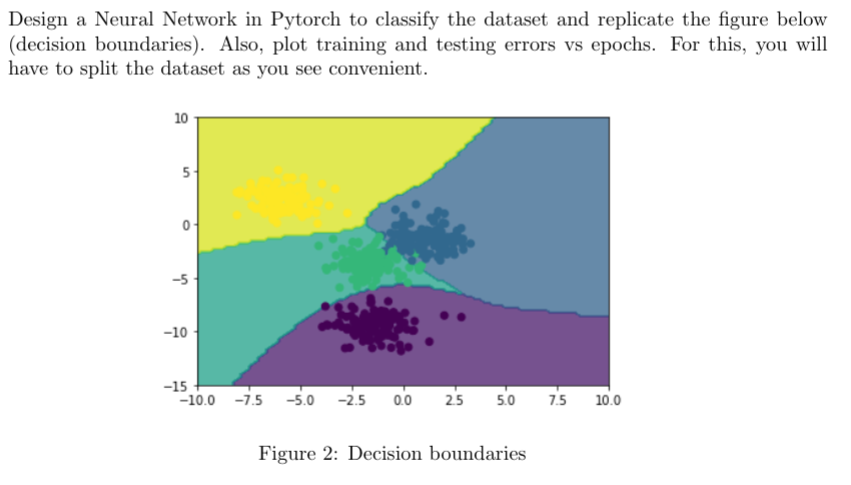

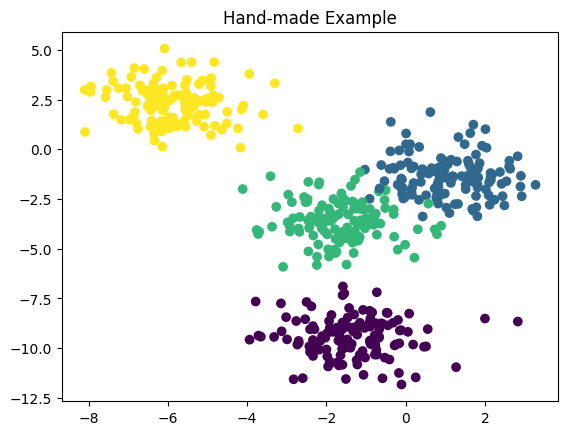

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
X,y = datasets.make_blobs(centers = 4,random_state=2,n_samples=500)
plt.scatter(X[:,0],X[:,1],c=y)
plt.title("Hand-made Example")
plt.show()

In [2]:
import torch
import torch.optim as optim
from torch import nn 
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cpu device


In [3]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
input_size = 2  # 2D points
hidden_size = 10  # Number of neurons in the hidden layer
output_size = 4  # 4 classes
# Instantiate the model, define the loss function and the optimizer
model = SimpleNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)



In [4]:
from torch.utils.data import DataLoader, TensorDataset, random_split
# Split the dataset into training and testing sets
# Convert numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Create TensorDataset
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Training loop
num_epochs = 250
train_losses = []
test_losses = []
best_test_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for points, labels in train_loader:
        # Forward pass
        outputs = model(points)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for points, labels in test_loader:
            outputs = model(points)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    # Save the model if test loss improves
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), 'best_model.pth')

    if(epoch % 25 == 0 or epoch == num_epochs-1):
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
        if(epoch == num_epochs-1):
            print(f'Best Test Loss: {best_test_loss:.4f}')

Epoch [1/250], Train Loss: 1.2281, Test Loss: 0.7769
Epoch [26/250], Train Loss: 0.1180, Test Loss: 0.0762
Epoch [51/250], Train Loss: 0.0726, Test Loss: 0.0433
Epoch [76/250], Train Loss: 0.0572, Test Loss: 0.0352
Epoch [101/250], Train Loss: 0.0515, Test Loss: 0.0304
Epoch [126/250], Train Loss: 0.0490, Test Loss: 0.0294
Epoch [151/250], Train Loss: 0.0457, Test Loss: 0.0264
Epoch [176/250], Train Loss: 0.0442, Test Loss: 0.0266
Epoch [201/250], Train Loss: 0.0536, Test Loss: 0.0257
Epoch [226/250], Train Loss: 0.0435, Test Loss: 0.0245
Epoch [250/250], Train Loss: 0.0422, Test Loss: 0.0251
Best Test Loss: 0.0235


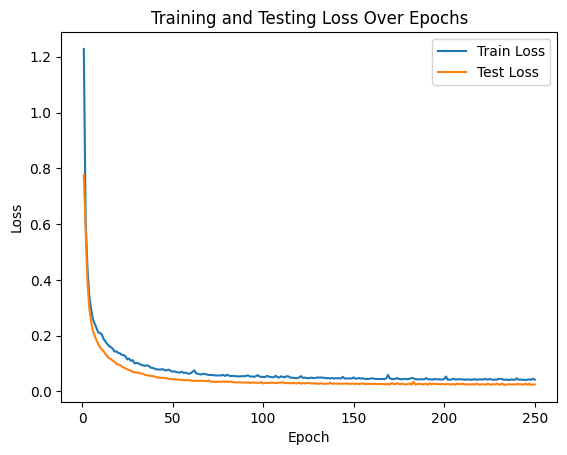

In [5]:
# Plot the training and testing error over the epochs
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.show()

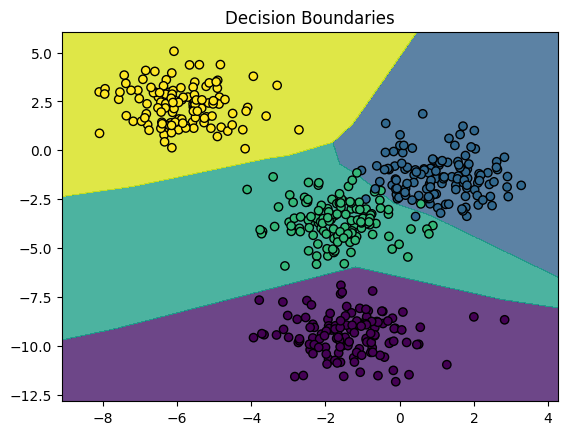

In [6]:
# Plot the decision boundaries
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid, dtype=torch.float32)
    with torch.no_grad():
        Z = model(grid_tensor)
    Z = Z.argmax(dim=1).numpy().reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', marker='o')
    plt.title('Decision Boundaries')
    plt.show()

plot_decision_boundary(model, X, y)